In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns


# Flughafen Netzwerk


In [2]:
summary_path = '../data/flughafen_netzwerk.csv'
summary_df = pd.read_csv(summary_path)

graph = nx.DiGraph()
for index, row in summary_df.iterrows():
    graph.add_node(
        row['source_airport'],
        name=row['source_name'],
        city=row['source_city'],
        country=row['source_country'],
        latitude=row['source_lat'],
        longitude=row['source_lon']
    )
    graph.add_node(
        row['destination_airport'],
        name=row['dest_name'],
        city=row['dest_city'],
        country=row['dest_country'],
        latitude=row['dest_lat'],
        longitude=row['dest_lon']
    )

for index, row in summary_df.iterrows():
    graph.add_edge(
        row['source_airport'],
        row['destination_airport'],
        airline=row['airline_name'],
        stops=row['stops'],
        distance=row['distance_km']
    )

print("Number of nodes:", graph.number_of_nodes())
print("Number of edges:", graph.number_of_edges())

def filter_graph_by_centrality(threshold):
    degree_centrality = nx.degree_centrality(graph)
    filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= threshold]
    return graph.subgraph(filtered_nodes), degree_centrality


Number of nodes: 3425
Number of edges: 37594


## Explorative Analyse


In [3]:
filtered_graph, degree_centrality = filter_graph_by_centrality(0.01)

print("Top 10 Nodes by Degree Centrality:")
degree_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in degree_sorted:
    print(f"{node}: {centrality:.4f}")

betweenness_centrality = nx.betweenness_centrality(filtered_graph)
print("\nTop 10 Nodes by Betweenness Centrality:")
betweenness_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in betweenness_sorted:
    print(f"{node}: {centrality:.4f}")

closeness_centrality = nx.closeness_centrality(filtered_graph)
print("\nTop 10 Nodes by Closeness Centrality:")
closeness_sorted = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in closeness_sorted:
    print(f"{node}: {centrality:.4f}")

try:
    eigenvector_centrality = nx.eigenvector_centrality(filtered_graph)
    print("\nTop 10 Nodes by Eigenvector Centrality:")
    eigenvector_sorted = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    for node, centrality in eigenvector_sorted:
        print(f"{node}: {centrality:.4f}")
except nx.PowerIterationFailedConvergence:
    print("\nEigenvector Centrality could not be calculated (convergence issues).")



--- Social Network Analysis ---

Top 10 Nodes by Degree Centrality:
FRA: 0.1393
CDG: 0.1373
AMS: 0.1352
IST: 0.1335
ATL: 0.1265
PEK: 0.1203
ORD: 0.1195
MUC: 0.1110
DME: 0.1104
DFW: 0.1086

Top 10 Nodes by Betweenness Centrality:
FRA: 0.0727
AMS: 0.0640
CDG: 0.0637
PEK: 0.0541
LHR: 0.0378
DXB: 0.0360
JFK: 0.0340
HKG: 0.0338
IST: 0.0320
PVG: 0.0279

Top 10 Nodes by Closeness Centrality:
FRA: 0.6270
AMS: 0.6163
CDG: 0.6141
LHR: 0.5897
MUC: 0.5863
IST: 0.5823
FCO: 0.5776
DXB: 0.5711
JFK: 0.5711
ZRH: 0.5647

Top 10 Nodes by Eigenvector Centrality:
AMS: 0.1689
FRA: 0.1685
CDG: 0.1617
MUC: 0.1512
LHR: 0.1406
FCO: 0.1405
BCN: 0.1324
ZRH: 0.1306
IST: 0.1286
BRU: 0.1259


## Analyse 1: Wichtigste Knotenflughäfen

Welche Flughäfen haben die meisten Verbindungen und sind wichtige Knotenpunkte (Hubs) im Netzwerk?


Degree-Assortativität des Netzwerks: -0.3215


Durchschnittlicher Cluster-Koeffizient des Netzwerks: 0.8533


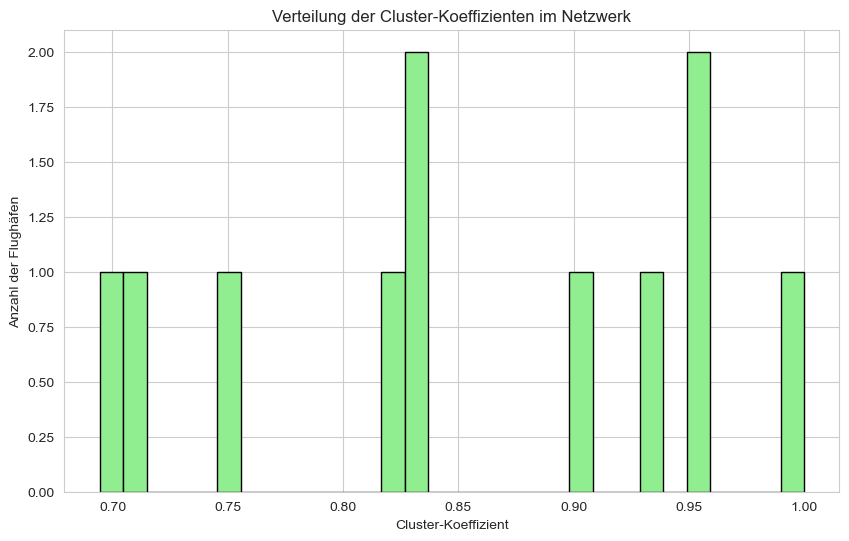

In [8]:
filtered_graph, degree_centrality = filter_graph_by_centrality(0.1)

geo_pos = {
    node: (data['longitude'], data['latitude'])
    for node, data in filtered_graph.nodes(data=True)
    if 'latitude' in data and 'longitude' in data
}

edge_x = []
edge_y = []
for edge in filtered_graph.edges():
    x0, y0 = geo_pos[edge[0]]
    x1, y1 = geo_pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scattergeo(
    lon=edge_x,
    lat=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_size = []
node_color = []
node_text = []
for node in filtered_graph.nodes(data=True):
    x, y = geo_pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    node_size.append(10 + degree_centrality[node[0]] * 50)
    node_color.append(betweenness_centrality[node[0]])
    node_text.append(f"{node[1]['name']} ({node[1]['city']}, {node[1]['country']})")

node_trace = go.Scattergeo(
    lon=node_x,
    lat=node_y,
    mode='markers',
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Betweenness Centrality')
    ),
    text=node_text,
    hoverinfo='text'
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Geographic Visualization of the Filtered Flughafen Netzwerk",
                    height=800,
                    showlegend=False,
                    geo=dict(
                        scope='world',
                        showland=True,
                        landcolor='rgb(243, 243, 243)',
                        showcountries=True,
                    )
                ))

fig.show()

degree_assortativity = nx.degree_assortativity_coefficient(filtered_graph)
print(f"Degree-Assortativität des Netzwerks: {degree_assortativity:.4f}")

# Visualisierung der Degree-Verteilung
degrees = [filtered_graph.degree(n) for n in filtered_graph.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title('Degree-Verteilung der Flughäfen im Netzwerk')
plt.xlabel('Degree')
plt.ylabel('Anzahl der Flughäfen')
plt.show()

# 6. Cluster-Koeffizienten und lokale Netzwerke
# Berechnung des durchschnittlichen Cluster-Koeffizienten
average_clustering = nx.average_clustering(filtered_graph.to_undirected())
print(f"Durchschnittlicher Cluster-Koeffizient des Netzwerks: {average_clustering:.4f}")

# Cluster-Koeffizient pro Knoten
clustering_per_node = nx.clustering(filtered_graph.to_undirected())

# Visualisierung der Cluster-Koeffizienten
clustering_values = list(clustering_per_node.values())
plt.figure(figsize=(10, 6))
plt.hist(clustering_values, bins=30, color='lightgreen', edgecolor='black')
plt.title('Verteilung der Cluster-Koeffizienten im Netzwerk')
plt.xlabel('Cluster-Koeffizient')
plt.ylabel('Anzahl der Flughäfen')
plt.show()


**Interaktive Karte**

Die Karte visualisiert Flughäfen, die im Netzwerk besonders zentral sind, basierend auf ihrer Degree-Zentralität.
Flughäfen mit einem Degree Centrality Score > 0.1 sind Knotenpunkte (Hubs), die eine grosse Anzahl von Verbindungen aufweisen.
Diese Flughäfen befinden sich hauptsächlich in Europa (z. B. Frankfurt, Amsterdam) sowie in strategisch wichtigen Regionen 
wie dem Nahen Osten (z. B. Dubai) und Nordamerika (z. B. Atlanta).

Interpretation:

- Flughäfen mit hoher Degree-Zentralität sind entscheidend für die Stabilität und Effizienz des Netzwerks.
- Ein Ausfall eines dieser Flughäfen (z. B. durch Wetter oder Streiks) könnte große Auswirkungen auf das gesamte Netzwerk haben.

**Degree-Assortativität des Netzwerks**

Wert: -0.3215 (negativer Wert)

Interpretation:

- Der negative Wert der Degree-Assortative zeigt, dass Flughäfen mit hohem Degree (viele Verbindungen) dazu neigen, mit Flughäfen mit niedrigem Degree (wenige Verbindungen) verbunden zu sein.
- Dies zeigt das unser Netzwerk eine Hub-and-Spoke-Struktur hat, grössere Hubs bedienen oft kleinere Flughäfen, um eine effiziente Netzabdeckung zu gewährleisten.

**Durchschnittlicher Cluster-Koeffizient**

Wert: 0.8533 (hoher Wert)

Interpretation:

- Der hohe durchschnittliche Cluster-Koeffizient deutet darauf hin, dass Flughäfen in lokalen Cliquen stark miteinander verbunden sind.
- Dies zeigt, dass viele Flughäfen in regionalen Netzwerken oder geografischen Gruppen eng zusammenarbeiten.
- Die Cluster-Koeffizienten verteilen sich im Bereich von 0.7 bis 1.0.
- Flughäfen mit einem Cluster-Koeffizienten nahe 1.0 gehören wahrscheinlich zu stark vernetzten regionalen Netzwerken, z. B. innerhalb eines Landes oder einer Region.
- Flughäfen mit einem geringeren Cluster-Koeffizienten könnten größere Hubs sein, die weniger lokale Verbindungen und mehr Fernverbindungen aufweisen.


## Analyse 2: Communities im Netzwerk

Können die globalen Flugrouten gruppiert werden und decken sich diese Communities mit den geografischen Gegebenheiten?


Anzahl der Flughäfen pro Community:
0    191
1    176
2    140
Name: count, dtype: int64

Durchschnittliche Grad-Zentralität pro Community:
1    0.034723
2    0.030167
0    0.028920
dtype: float64


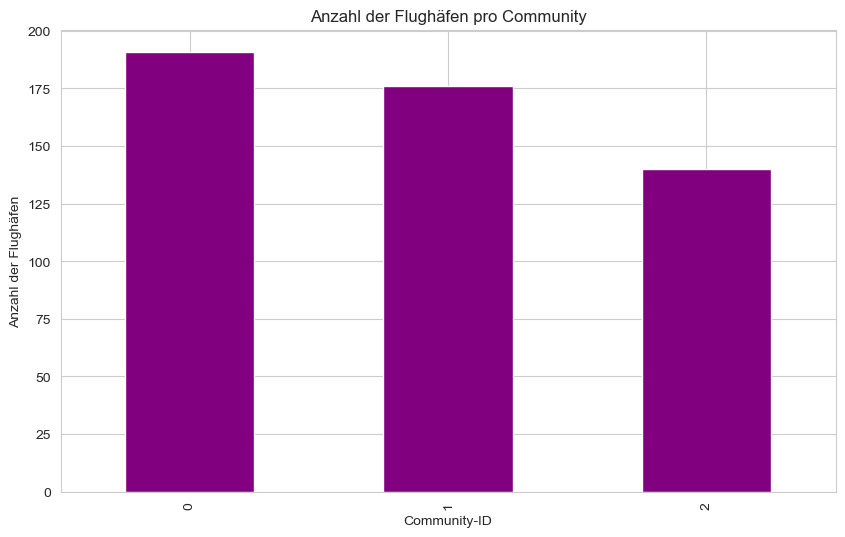

In [5]:
filtered_graph, degree_centrality = filter_graph_by_centrality(0.01)

from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(filtered_graph))
community_mapping = {}
for i, community in enumerate(communities):
    for node in community:
        community_mapping[node] = i
nx.set_node_attributes(filtered_graph, community_mapping, 'community')

geo_pos = {
    node: (data['longitude'], data['latitude'])
    for node, data in filtered_graph.nodes(data=True)
    if 'latitude' in data and 'longitude' in data
}

edge_x = []
edge_y = []
for edge in filtered_graph.edges():
    x0, y0 = geo_pos[edge[0]]
    x1, y1 = geo_pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scattergeo(
    lon=edge_x,
    lat=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_size = []
node_color = []
node_text = []
for node in filtered_graph.nodes(data=True):
    x, y = geo_pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    node_size.append(10 + degree_centrality[node[0]] * 50)
    node_color.append(node[1]['community'])
    node_text.append(f"{node[1]['name']} ({node[1]['city']}, {node[1]['country']}) - Community {node[1]['community']} ")

node_trace = go.Scattergeo(
    lon=node_x,
    lat=node_y,
    mode='markers',
    marker=dict(
        size=node_size,
        color=node_color,
        colorscale='Rainbow',
        showscale=True,
        colorbar=dict(title='Community')
    ),
    text=node_text,
    hoverinfo='text'
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Interactive Geographic Visualization of the Communities in Flughafen Netzwerk",
                    height=800,
                    showlegend=False,
                    geo=dict(
                        scope='world',
                        showland=True,
                        landcolor='rgb(243, 243, 243)',
                        showcountries=True,
                    )
                ))

fig.show()

community_sizes = pd.Series(community_mapping).value_counts()
print("Anzahl der Flughäfen pro Community:")
print(community_sizes)

community_centrality = {}
for node, community in community_mapping.items():
    if community not in community_centrality:
        community_centrality[community] = []
    community_centrality[community].append(degree_centrality[node])

average_centrality_per_community = {
    community: sum(centralities) / len(centralities)
    for community, centralities in community_centrality.items()
}
print("\nDurchschnittliche Grad-Zentralität pro Community:")
print(pd.Series(average_centrality_per_community).sort_values(ascending=False))

community_sizes.plot(kind='bar', color='purple', figsize=(10, 6))
plt.title('Anzahl der Flughäfen pro Community')
plt.xlabel('Community-ID')
plt.ylabel('Anzahl der Flughäfen')
plt.show()


TODO: Analyse der Grafik


## Analyse 3: Verbindungen vom Flughafen Zürich

Wie ist der Flughafen Zürich mit anderen Flughäfen verbunden? Welche Strecken, Airlines und Distanzmuster lassen sich identifizieren?

Anzahl der Verbindungen ab Zürich: 137
Anzahl der Verbindungen nach Zürich: 136

Längste Strecken ab Zürich:
     Von      Von Stadt Nach     Nach Stadt                        Airline  \
251  SIN      Singapore  ZRH         Zurich                     US Airways   
116  ZRH         Zurich  SIN      Singapore                     US Airways   
224  GRU      Sao Paulo  ZRH         Zurich  Swiss International Air Lines   
88   ZRH         Zurich  GRU      Sao Paulo  Swiss International Air Lines   
105  ZRH         Zurich  NRT          Tokyo             All Nippon Airways   
240  NRT          Tokyo  ZRH         Zurich             All Nippon Airways   
96   ZRH         Zurich  LAX    Los Angeles                United Airlines   
232  LAX    Los Angeles  ZRH         Zurich                United Airlines   
115  ZRH         Zurich  SFO  San Francisco                United Airlines   
250  SFO  San Francisco  ZRH         Zurich                United Airlines   

     Distanz (km)  
251  10305.6

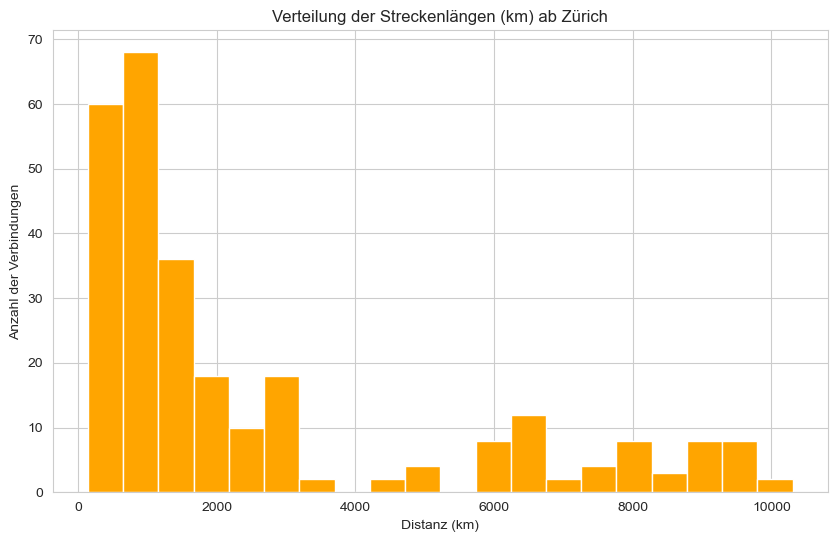

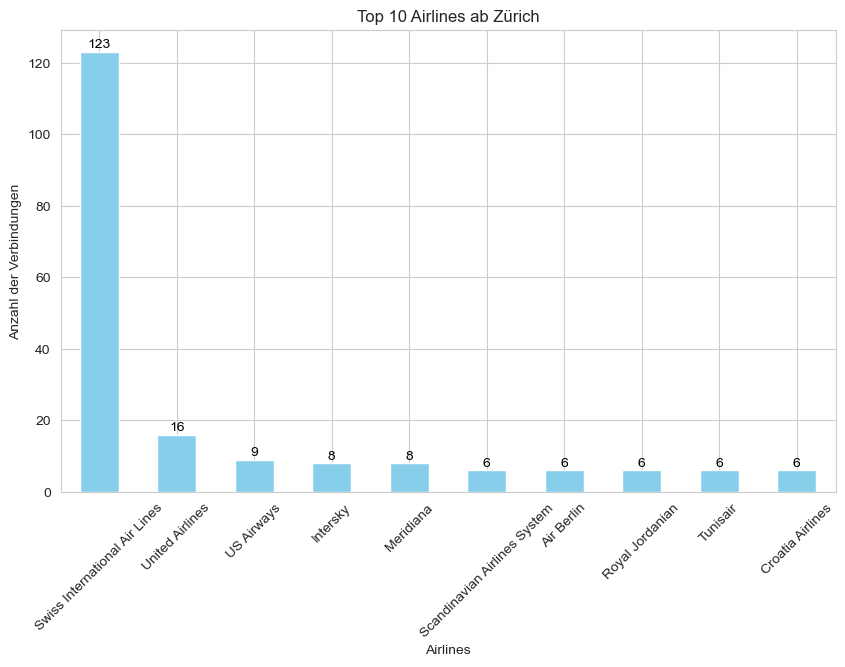

In [6]:
zurich_airport = 'ZRH'
zurich_connections = [
    (u, v, d)
    for u, v, d in graph.edges(data=True)
    if u == zurich_airport or v == zurich_airport
]

zurich_subgraph = nx.DiGraph()
for u, v, d in zurich_connections:
    zurich_subgraph.add_node(u, **graph.nodes[u])
    zurich_subgraph.add_node(v, **graph.nodes[v])
    zurich_subgraph.add_edge(u, v, **d)

print(f"Anzahl der Verbindungen ab Zürich: {zurich_subgraph.out_degree(zurich_airport)}")
print(f"Anzahl der Verbindungen nach Zürich: {zurich_subgraph.in_degree(zurich_airport)}")

zurich_routes = []
for u, v, d in zurich_subgraph.edges(data=True):
    airline = d.get('airline', 'Unknown')
    distance = d.get('distance', 'Unknown')
    zurich_routes.append({
        'Von': u,
        'Von Stadt': zurich_subgraph.nodes[u]['city'] if 'city' in zurich_subgraph.nodes[u] else 'Unknown',
        'Nach': v,
        'Nach Stadt': zurich_subgraph.nodes[v]['city'] if 'city' in zurich_subgraph.nodes[v] else 'Unknown',
        'Airline': airline,
        'Distanz (km)': distance
    })

zurich_routes_df = pd.DataFrame(zurich_routes)

top_airlines = zurich_routes_df['Airline'].value_counts().head(10)

longest_routes = zurich_routes_df.sort_values(by='Distanz (km)', ascending=False).head(10)
print("\nLängste Strecken ab Zürich:")
print(longest_routes[['Von', 'Von Stadt', 'Nach', 'Nach Stadt', 'Airline', 'Distanz (km)']])

# Histogramm der Streckenlängen
zurich_routes_df['Distanz (km)'].dropna().plot(kind='hist', bins=20, color='orange', figsize=(10, 6))
plt.title('Verteilung der Streckenlängen (km) ab Zürich')
plt.xlabel('Distanz (km)')
plt.ylabel('Anzahl der Verbindungen')
plt.show()

# Barplot der häufigsten Airlines ab Zürich 
ax = top_airlines.plot(kind='bar', color='skyblue', figsize=(10, 6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 10 Airlines ab Zürich')
plt.xlabel('Airlines')
plt.ylabel('Anzahl der Verbindungen')
plt.xticks(rotation=45)
plt.show()

# Interaktive Karte der Verbindungen
zurich_geo_pos = {
    node: (data['longitude'], data['latitude'])
    for node, data in zurich_subgraph.nodes(data=True)
    if 'latitude' in data and 'longitude' in data
}

edge_x = []
edge_y = []
for edge in zurich_subgraph.edges():
    x0, y0 = zurich_geo_pos[edge[0]]
    x1, y1 = zurich_geo_pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scattergeo(
    lon=edge_x,
    lat=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

node_x = []
node_y = []
node_color = []
node_text = []
for node in zurich_subgraph.nodes(data=True):
    x, y = zurich_geo_pos[node[0]]
    node_x.append(x)
    node_y.append(y)
    color = 'red' if node[0] == zurich_airport else 'blue'
    node_color.append(color)
    node_text.append(f"{node[1]['name']} ({node[1]['city']}, {node[1]['country']})")

node_trace = go.Scattergeo(
    lon=node_x,
    lat=node_y,
    mode='markers',
    marker=dict(
        size=10,
        color=node_color,
        opacity=0.7
    ),
    text=node_text,
    hoverinfo='text'
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Verbindungen des Flughafen Zürich",
                    height=800,
                    showlegend=False,
                    geo=dict(
                        scope='world',
                        showland=True,
                        landcolor='rgb(243, 243, 243)',
                        showcountries=True,
                    )
                ))

fig.show()

TODO: Analyse der Grafik


## Analyse 4: Langstecken Verbindungen

Welche Flughäfen haben viele Langstreckenverbindungen? Decken sich diese mit den zentralsten Flughäfen im Netzwerk?

Top 10 Flughäfen mit Langstreckenverbindungen:
Von
CDG    104
DXB     94
FRA     94
LHR     88
JFK     84
AMS     72
LAX     63
PEK     62
NRT     61
DOH     58
Name: count, dtype: int64


Top 10 zentralste Flughäfen im Netzwerk (nach degree centrality):
['FRA', 'CDG', 'AMS', 'IST', 'ATL', 'PEK', 'ORD', 'MUC', 'DME', 'DFW']

Gemeinsame Flughäfen zwischen Langstrecken und zentralsten Flughäfen:
{'CDG', 'AMS', 'PEK', 'FRA'}


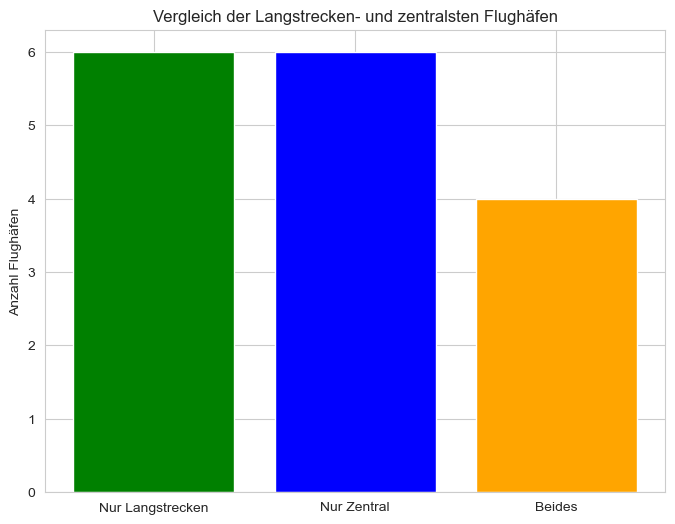

In [7]:
classified_routes = []
for u, v, d in graph.edges(data=True):
    distance = d.get('distance', 0)
    if distance < 1500:
        category = 'Kurzstrecke'
    elif 1500 <= distance <= 3500:
        category = 'Mittelstrecke'
    else:
        category = 'Langstrecke'

    classified_routes.append({
        'Von': u,
        'Nach': v,
        'Distanz (km)': distance,
        'Kategorie': category
    })

classified_routes_df = pd.DataFrame(classified_routes)
long_distance_counts = classified_routes_df[classified_routes_df['Kategorie'] == 'Langstrecke']['Von'].value_counts()
top_long_distance_airports = long_distance_counts.head(10)
print("Top 10 Flughäfen mit Langstreckenverbindungen:")
print(top_long_distance_airports)

ax = top_long_distance_airports.plot(kind='bar', color='green', figsize=(10, 6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.title('Top 10 Flughäfen mit Langstreckenverbindungen')
plt.xlabel('Flughäfen')
plt.ylabel('Anzahl der Langstreckenverbindungen')
plt.xticks(rotation=45)
plt.show()

centrality_sorted = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
top_central_airports = [airport for airport, _ in centrality_sorted[:10]]
common_airports = set(top_long_distance_airports.index) & set(top_central_airports)
print("Top 10 zentralste Flughäfen im Netzwerk (nach degree centrality):")
print(top_central_airports)
print("\nGemeinsame Flughäfen zwischen Langstrecken und zentralsten Flughäfen:")
print(common_airports)

categories = ['Nur Langstrecken', 'Nur Zentral', 'Beides']
counts = [
    len(set(top_long_distance_airports.index) - common_airports),
    len(set(top_central_airports) - common_airports),
    len(common_airports)
]

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['green', 'blue', 'orange'])
plt.title('Vergleich der Langstrecken- und zentralsten Flughäfen')
plt.ylabel('Anzahl Flughäfen')
plt.show()


Die Flughäfen mit den meisten Langstreckenverbindungen sind wenig überraschend hauptsächlich solche, die auf grund ihrer geografischen Lage z.B weit entfernte Kontinente verbinden (Amerika mit Europa).

Einige der zentralsten Flughäfen im Netzwerk haben auch viele Langstreckenverbindungen, wie z.B. Frankfurt (FRA), London Heathrow (LHR) oder Amsterdam Schiphol (AMS). 
Da diese Flughäfen viele Verbindungen haben, ist es wahrscheinlich, dass sie auch viele Langstreckenflüge an. Diese Flughäfen sind daher wichtige Knotenpunkte im globalen Flugnetzwerk.

Andere Flughäfen wie z.B Atlanta (ATL) oder München (MUC) sind zwar sehr Zentral, haben aber vergleichsweise wenige Langstreckenverbindungen. Sie verbinden andere Flughäfen hauptsächlich 
über Kurz- und Mittelstreckenflüge.

Es gibt jedoch auch Flughäfen wie z.B. Doha (DOH) oder Dubai (DXB), die viele Langstreckenverbindungen haben, aber nicht zu den zentralsten Flughäfen im Netzwerk gehören. 
Dies lässt vermutlich durch die geografische Lage dieser Orte erklären, da die meisten Flugrouten über diese Flughäfen führen, um Europa, Asien und Afrika zu verbinden.